# 量能回測實戰

## 交易邏輯

* 成交量增長象徵該檔股票受到投資者青睞，未來預期會有價格大幅波動情形

## 交易策略

* 當日成交量為前四日簡單移動平均的 2.5 倍時，視為買入訊號，於隔日買入。
* 當日成交量為前五日簡單移動平均的 0.75 倍時，視為賣出訊號，於隔日賣出。

## 資料來源

[官網文章:量能回測實戰]:https://www.tejwin.com/?s=%E9%87%8F%E8%83%BD%E5%9B%9E%E6%B8%AC%E5%AF%A6%E6%88%B0
[官網文章:量能回測實戰]

## 導入資料與套件

資料導入階段，我們使用 `os.environ` 設置環境變數，分別設定:

1. TEJAPI_KEY: 為購買 Tquant Lab 隨附的 api key，用於驗證個人身分。
2. mdate: 所欲抓取資料的時間範圍，格式為 "西元年份月份日期 西元年份月份日期"。
3. ticker: 所欲抓取資料的股價代碼，其中的 _IR0001_ 為大盤指數代碼。

於本次案例我們抓取台積電、創意、旺宏與台股大盤資料，時間區間設定為 2012-07-02 到 2022-07-02 之間。

In [1]:
import pandas as pd 
import numpy as np 
import tejapi
import os 

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'yourkey'
os.environ['mdate'] = '20120702 20220702'
os.environ['ticker'] = 'IR0001 2330 3443 2337'

# 使用 ingest 將股價資料導入暫存，並且命名該股票組合 (bundle) 為 tquant
!zipline ingest -b tquant 

Merging daily equity files:


[2023-07-26 02:01:00.179343] INFO: zipline.data.bundles.core: Ingesting tquant.


## 編輯交易策略

### 導入所需套件

In [2]:
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.data import EquityPricing

### 建立 Pipeline 函式

`Pipeline()` 提供使用者同時處理不同標的相關的量化指標與價量資料的功能，於本次案例我們用以處理:

* 各股成交量的四日簡單移動平均
* 各股成交量的五日簡單移動平均
* 各股的當日成交量

此外搭配 `screen` 與 `StaticAssets` 讓我們在每日計算上述指標時，過濾掉大盤資料 (*IR0001*)。讓之後在計算每個股票的成交量的四日簡單移動平均、成交量的五日簡單移動平均與當日成交量時，能跳過計算大盤指數。

In [3]:
bundle = bundles.load('tquant')
ir0001_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    sma_vol_win_4 = SimpleMovingAverage(inputs=[EquityPricing.volume], window_length=4)
    sma_vol_win_5 = SimpleMovingAverage(inputs=[EquityPricing.volume], window_length=5)
    curr_vol = EquityPricing.volume.latest
    
    return Pipeline(
        columns = {
            'sma_4':sma_vol_win_4,
            'sma_5':sma_vol_win_5,
            'curr_vol':curr_vol
        },
        screen = ~StaticAssets([ir0001_asset])
    )

### 建立 initialize 函式

`inintialize` 函式用於定義交易開始前的每日交易環境，與此例中我們設置:

* 流動性滑價
* 交易手續費
* 大盤報酬作為基準
* 將 Pipeline 導入交易流程中

In [4]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrategy')

### 建立 handle_date 函式

`handle_data` 函式用於處理每天的交易策略或行動，其中:

* condition1: 當日成交量大於四日簡單移動平均之 2.5 倍且現金部位大於 0 ，產生買入訊號。
* condition2: 當日成交量小於五日簡單移動平均之 0.75 倍，產生賣出訊號。

In [5]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')
    for i in out_dir.index: # 遍歷過每檔股票
        sma_vol_4 = out_dir.loc[i, 'sma_4']
        sma_vol_5 = out_dir.loc[i, 'sma_5']
        curr_vol = out_dir.loc[i, 'curr_vol']
        
        condition1 = (curr_vol > 2.5 * sma_vol_4) and (context.portfolio.cash > 0)
        condition2 = (curr_vol < 0.75 * sma_vol_5)
        
        if condition1:
            order(i, 10)
        elif condition2:
            order_target(i, 0)
        else:
            pass

### 建立 analyze 函式

多半用於繪製績效圖表，於本次案例將使用 pyfolio 繪製，故直接略過。

In [6]:
def analyze(context, perf):
    pass

## 執行交易策略

使用 `run_algorithm` 執行上述所編撰的交易策略，設置交易期間為 2012-07-02 到 2022-07-02，所使用資料集為 *tquant*，初始資金為 10,000 元。其中輸出的 __results__ 就是每日績效與交易的明細表。

In [7]:
results = run_algorithm(
    start = pd.Timestamp('2012-07-02', tz='UTC'),
    end = pd.Timestamp('2022-07-02', tz ='UTC'),
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e4,
    handle_data = handle_data
)

results

C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,period_open,period_close,benchmark_return,long_exposure,treasury_return,pnl,capital_used,short_exposure,orders,returns,...,treasury_period_return,algorithm_period_return,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,trading_days,period_label
2012-07-02 13:30:00+08:00,2012-07-02 09:01:00+08:00,2012-07-02 13:30:00+08:00,NaN,0.0,0.0,0.0000,0.0000,0.0,[],0.000000,...,0.0,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1,2012-07
2012-07-03 13:30:00+08:00,2012-07-03 09:01:00+08:00,2012-07-03 13:30:00+08:00,0.010450,0.0,0.0,0.0000,0.0000,0.0,"[{'id': '9d17e2fd712644c686d322e24c40fc18', 'd...",0.000000,...,0.0,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,2,2012-07
2012-07-04 13:30:00+08:00,2012-07-04 09:01:00+08:00,2012-07-04 13:30:00+08:00,0.006789,1947.4,0.0,-0.0855,-1947.4855,0.0,"[{'id': '9d17e2fd712644c686d322e24c40fc18', 'd...",-0.000009,...,0.0,-0.000009,-0.006131,0.002335,-9.165151,-9.165151,-0.000009,0.194742,3,2012-07
2012-07-05 13:30:00+08:00,2012-07-05 09:01:00+08:00,2012-07-05 13:30:00+08:00,-0.002474,1955.1,0.0,7.7000,0.0000,0.0,[],0.000770,...,0.0,0.000761,0.154572,-0.064349,7.819750,706.885842,-0.000009,0.195361,4,2012-07
2012-07-06 13:30:00+08:00,2012-07-06 09:01:00+08:00,2012-07-06 13:30:00+08:00,-0.002480,1948.0,0.0,-7.1000,0.0000,0.0,"[{'id': '43ec939b255d4efaaab36163955a90f1', 'd...",-0.000709,...,0.0,0.000051,0.005455,-0.002797,0.315410,0.520275,-0.000709,0.195361,5,2012-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27 13:30:00+08:00,2022-06-27 09:01:00+08:00,2022-06-27 13:30:00+08:00,0.017703,0.0,0.0,0.0000,0.0000,0.0,[],0.000000,...,0.0,0.041733,0.003933,0.003040,0.303824,0.701364,-0.025339,0.420975,2449,2022-06
2022-06-28 13:30:00+08:00,2022-06-28 09:01:00+08:00,2022-06-28 13:30:00+08:00,-0.005615,0.0,0.0,0.0000,0.0000,0.0,[],0.000000,...,0.0,0.041733,0.003933,0.003040,0.303762,0.701220,-0.025339,0.420975,2450,2022-06
2022-06-29 13:30:00+08:00,2022-06-29 09:01:00+08:00,2022-06-29 13:30:00+08:00,-0.009731,0.0,0.0,0.0000,0.0000,0.0,[],0.000000,...,0.0,0.041733,0.003935,0.003040,0.303700,0.701077,-0.025339,0.420975,2451,2022-06
2022-06-30 13:30:00+08:00,2022-06-30 09:01:00+08:00,2022-06-30 13:30:00+08:00,-0.025612,0.0,0.0,0.0000,0.0000,0.0,[],0.000000,...,0.0,0.041733,0.003942,0.003032,0.303638,0.700934,-0.025339,0.420975,2452,2022-06


## 視覺化與績效評估

### 生成 pyfolio 所需資料表

之後我們使用 pyfolio 進行績效視覺化與評估，首先使用 `extract_rets_pos_txn_from_zipline` 先將上述的 __results__ 資料表細分成以下部分:

* return: 投組每日報酬
* positions: 持有部位資料表
* transactions: 交易明細資料表

In [8]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

In [9]:
returns.head()

2012-07-02 00:00:00+08:00    0.000000
2012-07-03 00:00:00+08:00    0.000000
2012-07-04 00:00:00+08:00   -0.000009
2012-07-05 00:00:00+08:00    0.000770
2012-07-06 00:00:00+08:00   -0.000709
Name: returns, dtype: float64

In [10]:
positions.head()

sid,Equity(0 [2330]),Equity(1 [2337]),Equity(2 [3443]),cash
index,,,,
2012-07-04 00:00:00+08:00,812.0,95.4,1040.0,8052.5145
2012-07-05 00:00:00+08:00,810.0,95.1,1050.0,8052.5145
2012-07-06 00:00:00+08:00,809.0,94.0,1045.0,8052.5145
2012-07-09 00:00:00+08:00,0.0,0.0,1015.0,8945.3575
2012-07-10 00:00:00+08:00,0.0,0.0,980.0,8945.3575


In [11]:
transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2012-07-04 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),81.20,9d17e2fd712644c686d322e24c40fc18,10,None,2012-07-04 13:30:00+08:00,-812.0
2012-07-04 05:30:00+00:00,Equity(1 [2337]),Equity(1 [2337]),9.54,fcb751a7e39845db94df1d06b7ecab26,10,None,2012-07-04 13:30:00+08:00,-95.4
2012-07-04 05:30:00+00:00,Equity(2 [3443]),Equity(2 [3443]),104.00,76a9901f4c994acc9c295e33c85ddf92,10,None,2012-07-04 13:30:00+08:00,-1040.0
2012-07-09 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),80.00,43ec939b255d4efaaab36163955a90f1,-10,None,2012-07-09 13:30:00+08:00,800.0
2012-07-09 05:30:00+00:00,Equity(1 [2337]),Equity(1 [2337]),9.29,18b86f4b87c74756a1f760cab4fe0d5b,-10,None,2012-07-09 13:30:00+08:00,92.9


### 製作投資績效表

使用 `show_perf_stats()` 製作績效表，可以快速計算投資常用績效與風險指標。

In [12]:
import pyfolio as pf 
benchmark_rets = results['benchmark_return']
pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

C:\Users\Admin\anaconda3\envs\zipline-tej\lib\site-packages\empyrical\stats.py:1529: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(np.percentile(returns, 95)) / np.abs(


Start date,2012-07-02
End date,2022-07-01
Total months,116
,Backtest
Annual return,0.421%
Cumulative returns,4.173%
Annual volatility,1.416%
Sharpe ratio,0.30
Calmar ratio,0.17
Stability,0.59
Max drawdown,-2.534%


### 製作且繪製投組成份表格

使用 `show_and_plot_top_positions()` 與 `get_percent_alloc()` 製作且繪製各股於交易期間的成分佔比。

Top 10 long positions of all time,max
sid,
3443,42.10%
2337,13.59%
2330,8.12%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3443,42.10%
2337,13.59%
2330,8.12%


<AxesSubplot:title={'center':'Portfolio allocation over time, only top 10 holdings'}, xlabel='index', ylabel='Exposure by holding'>

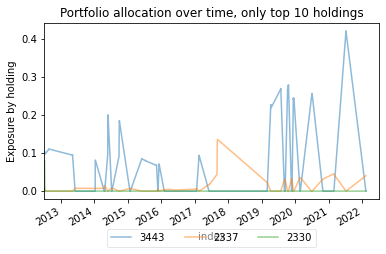

In [13]:
pf.plotting.show_and_plot_top_positions(returns, positions_alloc=pf.pos.get_percent_alloc(positions))

### 繪製基準 (benchmark) 與投組累計報酬率

使用 `plot_rolling_returns()` 繪製，本案例的基準為大盤報酬率。

<AxesSubplot:ylabel='Cumulative returns'>

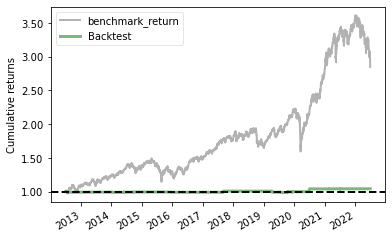

In [14]:
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)

### 繪製六個月的滾動波動度

使用 `plot_rolling_volatility()` 繪製。

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

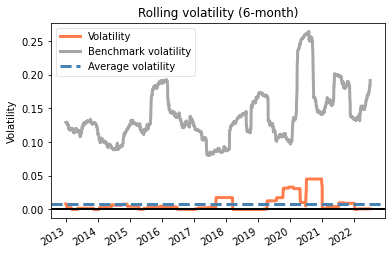

In [15]:
pf.plotting.plot_rolling_volatility(returns, factor_returns=benchmark_rets)

### 繪製六個月的滾動夏普值

使用 `plot_rolling_sharpe()` 繪製。

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

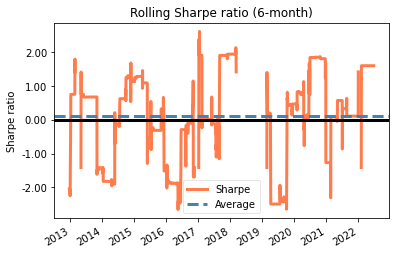

In [16]:
pf.plotting.plot_rolling_sharpe(returns)